# Banknote Authentication via Least Squares

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>Your aim is to predict whether a given banknote is authentic given a number of measures. Using the <b>least square</b> procedure create a classifier. Then, create the confusion matrix for the training set. If the logical assumption <i>"If the prediction value > $0.5$, then classify the item as $1$, otherwise as $0$</i>." leads to serious unbalancing number of false negative and false positive responses, try to find - heuristically - a value that balance the two numbers. For this threshold, run your model for the test set. Give the confusion matrix for the test set, and the error rates for the 2 sets. Finally, follow any appropriate transformation technique and try to increase the accuracy of the model.</p>

## *Table of Contents*

- [*1. Libraries*](#libraries)
- [*2. Data Collection & Cleansing*](#data)
- [*3. Least Squares Classifier*](#ls_classifier)
    - [*3.1. Predictions*](#predictions)
    - [*3.2. Confusion Matrix*](#confusion_matrix)
    - [*3.3. Fine Tune Alpha*](#tune_alpha)
    - [*3.4. Predictions (with tuned alpha)*](#predictions_alpha)
- [*4. Data Transformation*](#data_transformation)
    - [*4.1. Shapiro-Wilk Test*](#shapiro_wilk)
    - [*4.2. Data Normalization*](#data_normalization)
- [*5. Least Squares Classifier w. Normalized Data*](#ls_classifier_normalized)
    - [*5.1. Fine Tune Alpha*](#tune_alpha_normalized)
    - [*5.2. Predictions (with tuned alpha)*](#predictions_normalized)

---

## 1. Libraries <a class='anchor' id='libraries'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import math
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler

## 2. Data Collection & Cleansing <a class='anchor' id='data'></a>

##### *Read the data*

In [2]:
# read training data
x_train = pd.read_csv('./data/train_backnotes.csv')
y_train = pd.read_csv('./data/train_backnotes_l.csv')

# read test data
x_test = pd.read_csv('./data/test_backnotes.csv')
y_test = pd.read_csv('./data/test_backnotes_l.csv')

# preview x train
x_train.head()

,Unnamed: 0,variance,skewness,kurtosis,entropy,output,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,466,1.1472,3.59850,1.9387,-0.43406,0,NaN,NaN,NaN
1,909,-1.7322,-9.28280,7.7190,-1.71680,1,NaN,NaN,NaN
2,1025,-1.1022,-5.83950,4.5641,0.68705,1,NaN,NaN,NaN
3,1134,-1.7063,2.79560,-2.3780,-2.34910,1,NaN,NaN,NaN
4,55,4.8265,0.80287,1.6371,1.18750,0,NaN,NaN,NaN


##### *Create a function to clean x and y sets*

In [3]:
# function to fix x and y sets
def clean_x_and_y_sets(x_set, y_set):
    
    # fix x set
    x_set.set_index(x_set.columns[0], inplace=True)
    x_set.index.name = None
    x_set = x_set.iloc[:,:4]
    
    # fix y set
    y_set.set_index(y_set.columns[0], inplace=True)
    y_set.index.name = None
    
    return x_set, y_set

# execute the function
x_train, y_train = clean_x_and_y_sets(x_train, y_train)
x_test, y_test = clean_x_and_y_sets(x_test, y_test)

# store the sets in a dictionary
sets = {'train': [x_train, y_train], 'test': [x_test, y_test]}

# preview x train
x_train.head()

,variance,skewness,kurtosis,entropy
466,1.1472,3.59850,1.9387,-0.43406
909,-1.7322,-9.28280,7.7190,-1.71680
1025,-1.1022,-5.83950,4.5641,0.68705
1134,-1.7063,2.79560,-2.3780,-2.34910
55,4.8265,0.80287,1.6371,1.18750


## 3. Least Squares Classifier <a class='anchor' id='ls_classifier'></a>

### *3.1. Predictions* <a class='anchor' id='predictions'></a>

##### *Define a function to create a least squares classifier and make predictions (on the x train)*

- $\hat{\theta}=(X^{T}X)^{-1}(X^{T}y)$

In [4]:
# function to create a least squares classifier and make predictions
def least_squares_classifier(x_set, y_set, alpha=0.5):
    
    # function to calculate theta estimates
    # aka coefficients for each feature
    def get_thetas(X, Y):
        thetas = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
        return thetas
    
    # get thetas (coefficients)
    thetas = get_thetas(x_set, y_set)
    
    # make predictions
    preds = np.dot(x_set, thetas) 
    y_set['preds'] = preds
    
    # classify the predictions
    y_set['predicted_class'] = np.where(y_set.preds - alpha > 0, 1, 0)
    
    return y_set

# execute the function
y_train = least_squares_classifier(x_train, y_train)

# preview y train
y_train.head()

,output,preds,predicted_class
466,0,-0.022009,0
909,1,0.662349,1
1025,1,0.209284,0
1134,1,0.269918,0
55,0,-0.416705,0


### *3.2. Confusion Matrix* <a class='anchor' id='confusion_matrix'></a>

##### *Define a function to plot a confusion matrix with the results of the least square classifier (on the y train)*

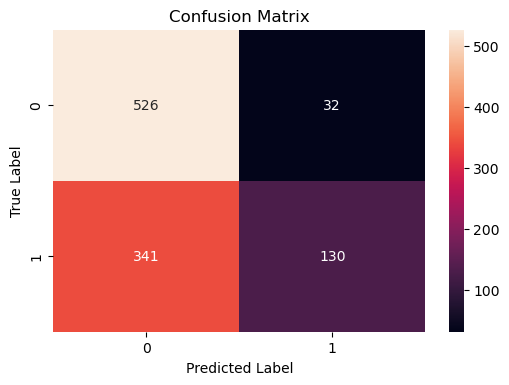

In [5]:
# function to plot confusion matrix
def plot_confusion_matrix(y_true, y_preds):
    
    # compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_preds)
    
    # plot confusion matrix
    plt.figure(dpi=100,facecolor='white')
    sns.heatmap(conf_matrix, annot = True, fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('./images/confusion_matrix_prior_tuning_alpha.svg')
    plt.show()
    
    return

# execute the function
_ = plot_confusion_matrix(y_train.output, y_train.predicted_class)

- As we see from the confusion matrix, there is a serious unbalance between false negative and false positive predictions
- Therefore, we will try to find - *heuristically* - a value of $\alpha$ that balances the two numbers

### *3.3. Fine Tune Alpha* <a class='anchor' id='tune_alpha'></a>

##### *Define a function to find the optimal value of $α$*

In [6]:
# function to tune alpha
def tune_alpha(x_set, y_set, alphas):
    
    # initialize alpha
    best_alpha = math.pow(10,10)
    
    # initialize the difference
    # between false negative and false positive
    best_fn_minus_fp = math.pow(10,10)
    
    print('Searching for best alpha...')
    
    # loop through alphas
    for alpha in alphas:
        
        # make predictions
        y_set = least_squares_classifier(x_set, y_set, alpha)
        
        # compute confusion matrix
        conf_matrix = confusion_matrix(y_set.iloc[:,0], y_set.iloc[:,-1])
        tn, fp, fn, tp = confusion_matrix(y_set.iloc[:,0], y_set.iloc[:,-1]).ravel()
        
        # compute the difference
        # between false negative and false positive
        # for the alpha in loop
        fn_minus_fp = abs(fn-fp)
        
        # store best results
        if fn_minus_fp < best_fn_minus_fp:
            best_alpha = alpha
            best_fn_minus_fp = fn_minus_fp
            
    print('Searching for best alpha... Found!', end='\n\n')
    print(f'The difference between FP and FN is {best_fn_minus_fp}.', end='\n\n')
    print(f'The best value of alpha is {round(best_alpha,3)}.')
    
    return best_alpha

# list of alphas to try
alphas = np.arange(-2, 2, 0.001)

# execute the function
alpha = tune_alpha(x_train, y_train, alphas)

Searching for best alpha...
Searching for best alpha... Found!

The difference between FP and FN is 1.

The best value of alpha is 0.108.


- Now that we found the optimal value of $\alpha$, we can run the model again and see the results
- We will run the model both for train and test set
- For each set, we will display the error rate and plot the confusion matrix and the ROC curve

### *3.4. Predictions (with tuned alpha)* <a class='anchor' id='predictions_alpha'></a>

##### *Define function to run the model, using the optimal alpha, and plot the results*


# 1 - train set
Alpha: 0.108
Error Rate: 24.4%
---------------------------------------------------------------------------------------------------------------------


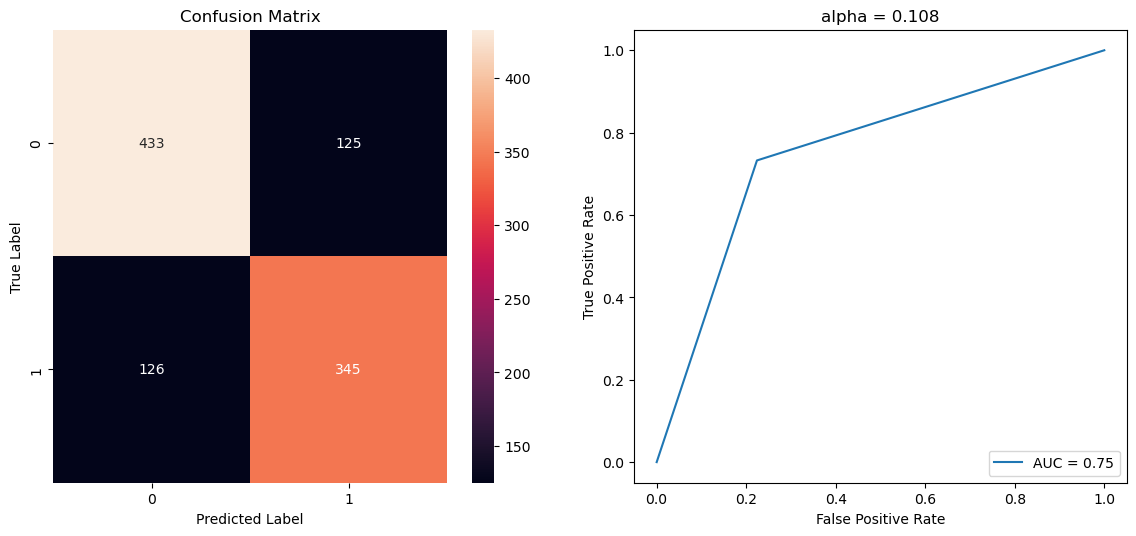


# 2 - test set
Alpha: 0.108
Error Rate: 26.2%
---------------------------------------------------------------------------------------------------------------------


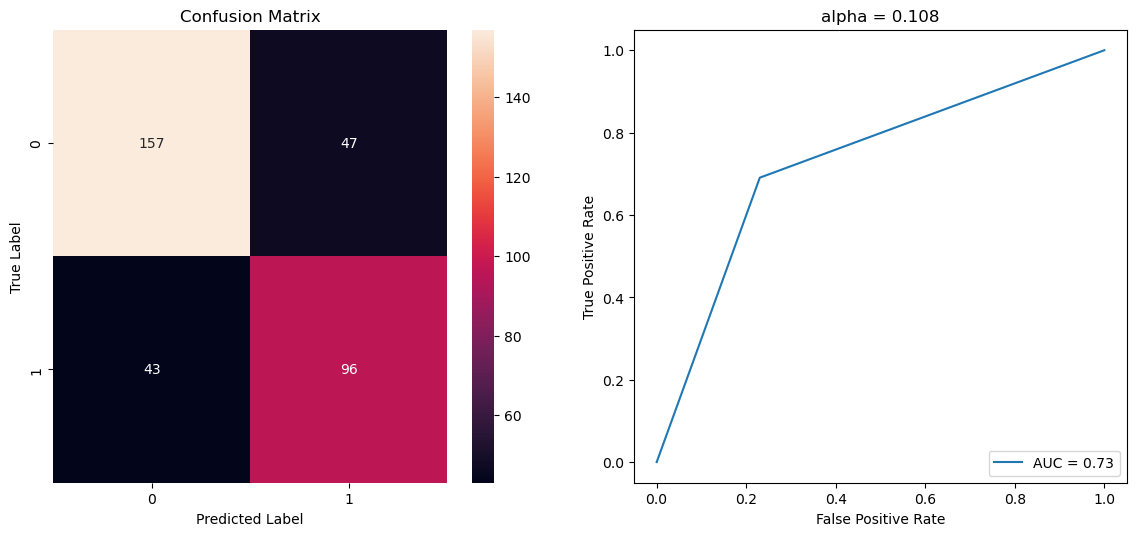

In [7]:
# function to run the model
def run_model_and_plot_results(sets, alpha, scaled=False):
    
    # loop through train and test set
    for i, (key, (x_set, y_set)) in enumerate(sets.items()):
        
        # make predictions
        y_set = least_squares_classifier(x_set, y_set, alpha)
        
        # compute confusion matrix
        conf_matrix = confusion_matrix(y_set.iloc[:,0], y_set.iloc[:,-1])
        
        # compute error rate
        error_rate = 1 - accuracy_score(y_set.iloc[:,0], y_set.iloc[:,-1])
    
        # print results
        print('\n' + f'# {i+1} - {key} set')
        print('='*117)
        print(f'Alpha: {round(alpha,3)}')
        print(f'Error Rate: {error_rate*100:.3}%')
        print('-'*117)
    
        # create figure
        fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=100,facecolor='white')
        # plot confusion matrix
        sns.heatmap(conf_matrix, annot = True, fmt='g', ax=ax[0])
        ax[0].set_xlabel('Predicted Label')
        ax[0].set_ylabel('True Label')
        ax[0].set_title('Confusion Matrix')
        # plot ROC curve
        fpr, tpr, _ = roc_curve(y_set.iloc[:,0], y_set.iloc[:,-1])
        auc = roc_auc_score(y_set.iloc[:,0], y_set.iloc[:,-1])
        ax[1].plot(fpr, tpr, label=f'AUC = {round(auc,2)}')
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title(f'alpha = {round(alpha,3)}')
        ax[1].legend(loc=4)
        plt.tight_layout(pad=3)
        if scaled:
            fig.savefig(f'./images/confusion_matrix_and_roc_curve_for_scaled_{key}_set.svg')
        else:
            fig.savefig(f'./images/confusion_matrix_and_roc_curve_for_{key}_set.svg')
        plt.show()
    
    return

# execute function
_ = run_model_and_plot_results(sets, alpha)

- Great, we managed to balance the number of false negative and false positive predictions
- However, we still don't have the best possible results
- A great way to increase the accuracy of our results would be to scale the values of our features before training the model

## 4. Data Transformation <a class='anchor' id='data_transformation'></a>

- To decide which type of scaling to apply, let's run some tests
- We will use the ***Shapiro-Wilk*** test to detect whether the population of features under consideration is normally distributed

### *4.1. Shapiro-Wilk Test* <a class='anchor' id='shapiro_wilk'></a>

*Hypothesis Testing*
- $H0$: The sample (obtained from `feature_name`) comes from a normal distribution
- $H1$: The sample (obtained from `feature_name`) does not come from a normal distribution

*Results*
- We ***reject*** the null hypothesis ($H0$) if $p$-value < $0.05$

##### *Define function to perform the Shapiro-Wilk test and plot the results*


# 1 - variance
Skewness: -0.13919389842144453
-------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9808167219161987, pvalue=3.330156150838093e-10)
-------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


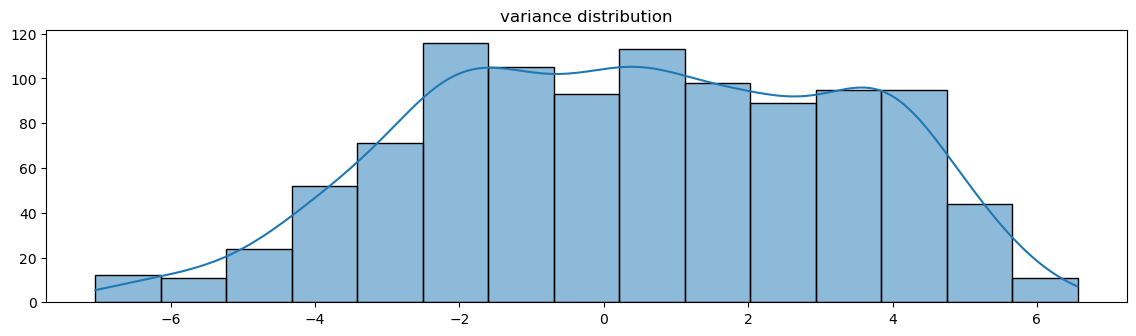


# 2 - skewness
Skewness: -0.3728686651027892
-------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9755833745002747, pvalue=6.380407487072137e-12)
-------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


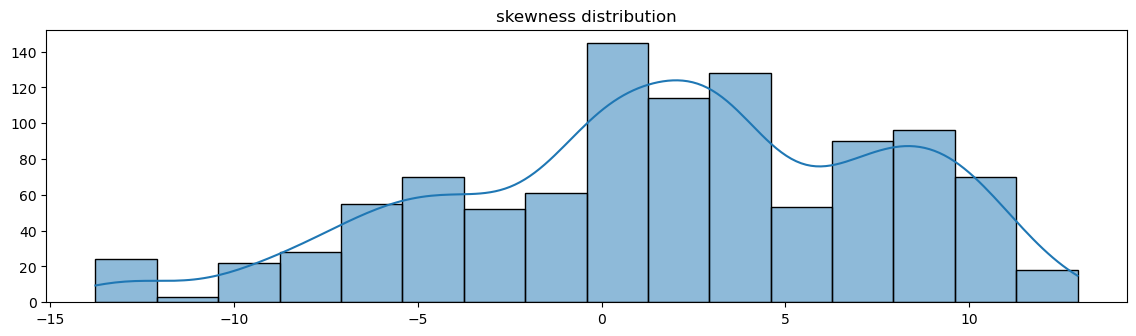


# 3 - kurtosis
Skewness: 1.1089627245460085
-------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9224711656570435, pvalue=2.913420085420282e-22)
-------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


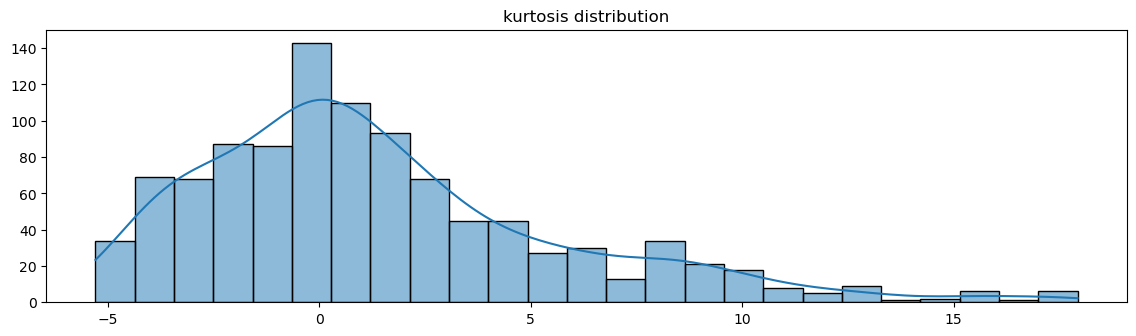


# 4 - entropy
Skewness: -1.0332033156903635
-------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.915263831615448, pvalue=3.33700248257556e-23)
-------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


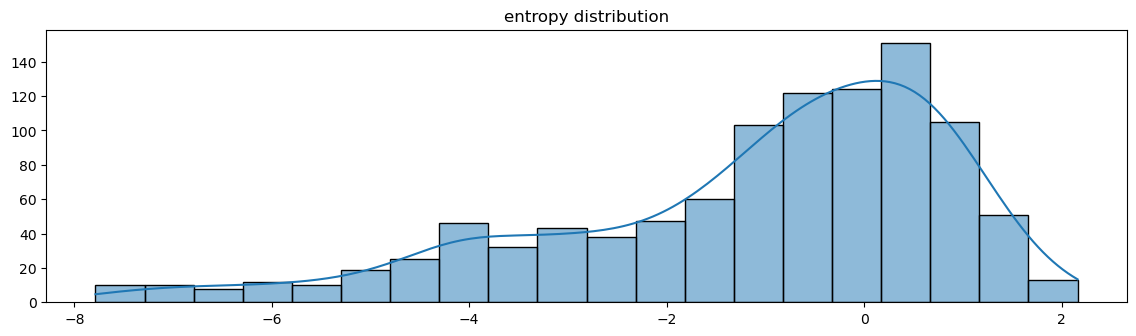

In [8]:
# function to run Shapiro-Wilk test
def shapiro_wilk_test(df, i, feature):

    # calculate skewnees
    skewness = df[feature].skew()
    
    # select a sample of 1000 data points
    sample = df[feature].sample(n=1000, random_state=1)
    
    # test for normal distribution
    shapiro_wilk = shapiro(sample)
    norm_distrib = ('True' if shapiro_wilk.pvalue > 0.05 else 'False')
    
    # print results
    print('\n' + f'# {i+1} - {feature}')
    print('='*115)
    print(f'Skewness: {skewness}')
    print('-'*115)
    print(f'Shapiro Wilk test: {shapiro_wilk}')
    print('-'*115)
    print(f'Normal Distribution: {norm_distrib}')
    print('='*115)
    
    # plot the histogram
    plt.figure(figsize=(12,4), dpi=100, facecolor='white')
    sns.histplot(df[feature], kde=True)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f'{feature} distribution')
    plt.tight_layout(pad=3)
    plt.savefig(f'./images/shapiro_wilk_{feature}.svg')
    plt.show()
    
    return

# execute the function
_ = [shapiro_wilk_test(x_train, i, feature) for i, feature in enumerate(x_train.columns)]

- According to the graphs, none of the features seems to follow a normal distribution
- Moreover, the $p$***-value*** obtained from the Shapiro-Wilk test is less than $5$%, indicating that none of the samples tested comes from a normal distribution
- Therefore, we ***reject*** the null hypothesis

### *4.2. Data Normalization* <a class='anchor' id='data_normalization'></a>

- As a result of the previous test, we will scale these features using `MinMaxScaler`

##### *Scale the data using `MinMaxScaler`*

In [9]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test data
x_train_scaled = mms.fit_transform(x_train)
x_test_scaled = mms.transform(x_test)

# update the dict with the scaled sets
sets = {'train': [x_train_scaled, y_train], 'test': [x_test_scaled, y_test]}

## 5. Least Squares Classifier w. Normalized Data <a class='anchor' id='ls_classifier_normalized'></a>

### *5.1. Fine Tune Alpha* <a class='anchor' id='tune_alpha_normalized'></a>

##### *Find the new optimal value of $\alpha$*

In [10]:
# tune the alpha
# to minimize the difference
# between false negatives and false positives
new_alpha = tune_alpha(x_train_scaled, y_train, alphas)

Searching for best alpha...
Searching for best alpha... Found!

The difference between FP and FN is 0.

The best value of alpha is 0.486.


### *5.2. Predictions (with tuned alpha)* <a class='anchor' id='predictions_normalized'></a>

##### *Run the model, using the new optimal alpha, and plot the results*


# 1 - train set
Alpha: 0.486
Error Rate: 19.0%
---------------------------------------------------------------------------------------------------------------------


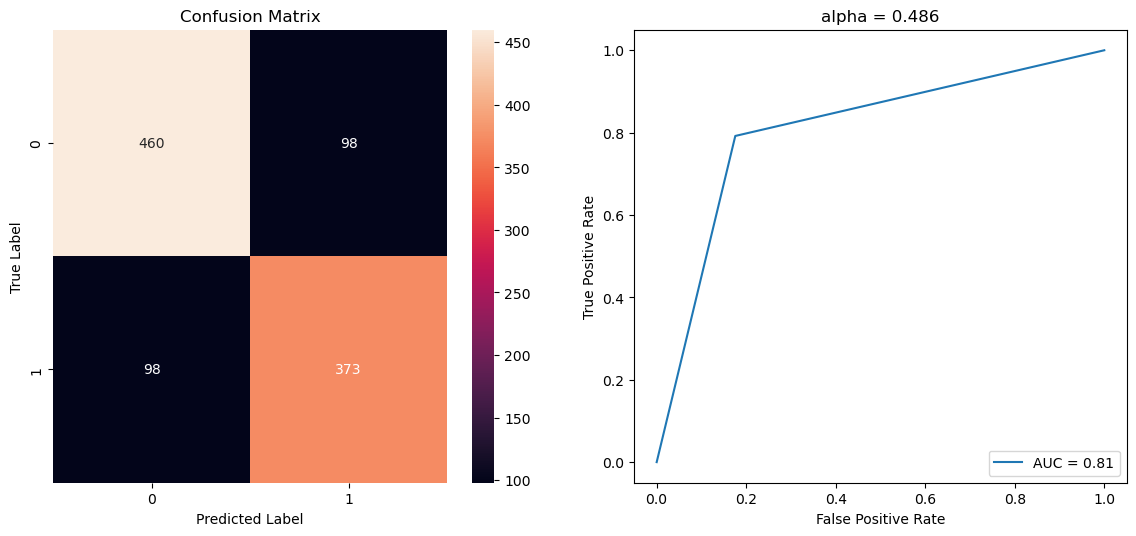


# 2 - test set
Alpha: 0.486
Error Rate: 23.6%
---------------------------------------------------------------------------------------------------------------------


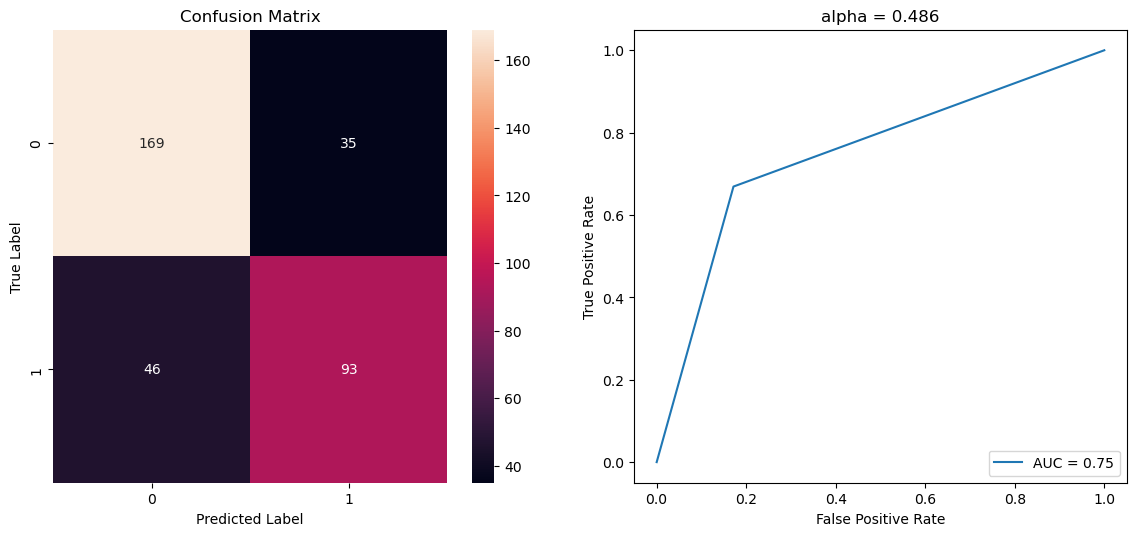

In [11]:
# run again the least squares classifier
# using the optimal alpha found for the scaled data
_ = run_model_and_plot_results(sets, new_alpha, True)

##### *Comments*

- Scaling our features results in a different optimal alpha value
- For this new alpha value, even though the difference between false positive and false negative is bigger that before, the error rate is smaller
- Also, looking at the graphs for both for training and test set, we see that when the model is trained on the scaled features, it yields higher AUC score

---

*Thank you!*

---